# Predicting the Success of A Kickstarter Campaign
Part 1. Initial screening of an assortment of ML models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from sqlalchemy import create_engine

from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, 
                             precision_recall_curve, auc)

from sklearn.cross_validation import train_test_split 
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler 

from xgboost import XGBClassifier

import datetime
import warnings
import os

warnings.filterwarnings("ignore")

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
pd.read_sql_query('''SELECT state, category_main, category_name, backers_count, pct_goal_achieved, usd_pledged, usd_goal, country, currency, campaign_length, staff_pick, blurb_length, launched FROM kickstarter_data_ds2 LIMIT 5''',engine)
df['idx'] = df['id']
df = df.set_index('idx')
df = df.drop(['index'],1)
print(df.shape)
df.head()

(163425, 19)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,0,B.Y. Eidelman,16
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,1,Holly Weist,5
1647325451,1647325451,Code Switch,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,1,Alba Roland,23
727157486,727157486,Rain Dog Farm,0,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,0,Charlie Wainger,9
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,1,D. H. de Bruin,22


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df = df[['state','category_name','backers_count','usd_goal','country','currency','campaign_length',
        'staff_pick','blurb_length']]
df = df.dropna()

df.shape

(38401, 9)

In [7]:
df.columns

Index(['state', 'category_name', 'backers_count', 'usd_goal', 'country',
       'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df[['category_name', 'country','currency']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(38401, 182)
Index(['category_name_Academic', 'category_name_Accessories',
       'category_name_Action', 'category_name_Animals',
       'category_name_Animation', 'category_name_Anthologies',
       'category_name_Apparel', 'category_name_Apps',
       'category_name_Architecture', 'category_name_Art Books',
       ...
       'currency_USD', 'state', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object', length=182)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38401 entries, 1396766240 to 1094069811
Columns: 182 entries, category_name_Academic to blurb_length
dtypes: float64(1), int64(5), object(3), uint8(173)
memory usage: 10.5+ MB


In [9]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
df = df.dropna()
X = df.drop(['state','state','category_name', 'backers_count', 'country', 'currency'], 1)
y = df['state']

print(X.shape)

(38401, 177)


## Assumptions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(26880, 177) (26880,)
(11521, 177) (11521,)


In [11]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Phase 1: Initial Check on All Models

In [12]:
# Define models to test
model_list = [['GaussianNB', GaussianNB()], 
                ['BernoulliNB', BernoulliNB(alpha=0.5)], 
                ['MultinomialNB', MultinomialNB(alpha=0)],
                ['DecisionTree', DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best')], 
                ['KNN', KNeighborsClassifier(27)], # best k from KNN model below; scale data
                ['RandomForest', RandomForestClassifier(max_features='auto',n_estimators=1000)], 
                ['GradientBoost', GradientBoostingClassifier(n_estimators=500)],
                ['AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                      base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best'),
                      n_estimators=2)],
                ['XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)],
                ['LogisticRegression', LogisticRegression(C=1000, penalty='l1')],          
                ['SVM', SVC(C=10,gamma=0.001,probability=True)]] # scale data; F1 0.57

model_list_s = [['KNN', KNeighborsClassifier(27)], # best k from KNN model below; scale data
                ['LogisticRegression', LogisticRegression(C=1000, penalty='l1')], # scale data
                ['SVM', SVC(C=10,gamma=0.001,probability=True)]] # scale data

# Calculate metrics for each model
roc = {}
results_dict = {}
for model in model_list:
    if model in model_list_s:
        X_train = X_train_s
        X_test = X_test_s
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision_1 = []
    precision_0 = []
    recall_1 = []
    recall_0 = []
    f1_1 = []
    f1_0 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision_1.append(precision_score(y_test, y_pred ,pos_label=1))
        precision_0.append(precision_score(y_test, y_pred ,pos_label=0))
        recall_1.append(recall_score(y_test, y_pred, pos_label=1))
        recall_0.append(recall_score(y_test, y_pred, pos_label=0))
        f1_1.append(f1_score(y_test, y_pred, pos_label=1))
        f1_0.append(f1_score(y_test, y_pred, pos_label=0))
        auc.append(roc_auc_score(y_test, y_pred))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision_1 = np.mean(precision_1)
    mean_precision_0 = np.mean(precision_0)
    mean_recall_1 = np.mean(recall_1)
    mean_recall_0 = np.mean(recall_0)
    mean_f1_1 = np.mean(f1_1)
    mean_f1_0 = np.mean(f1_0)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score), mean_auc
    results_dict[model_name] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, "precision_f": mean_precision_0, "recall_s": mean_recall_1, "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0, "auc": mean_auc}
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))  

GaussianNB(priors=None)
	Accuracy: 0.578856002083
	AUC: 0.535151254992


[[ 443 4758]
 [  94 6226]]
             precision    recall  f1-score   support

          0       0.82      0.09      0.15      5201
          1       0.57      0.99      0.72      6320

avg / total       0.68      0.58      0.46     11521

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.732575297283
	AUC: 0.735585978475


[[3987 1214]
 [1867 4453]]
             precision    recall  f1-score   support

          0       0.68      0.77      0.72      5201
          1       0.79      0.70      0.74      6320

avg / total       0.74      0.73      0.73     11521

MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
	Accuracy: 0.613748806527
	AUC: 0.582002000589


[[1327 3874]
 [ 576 5744]]
             precision    recall  f1-score   support

          0       0.70      0.26      0.37      5201
          1       0.60      0.91      0.72      6320

avg / total       0.64      0

In [13]:
# rc = pd.DataFrame(roc)
# rc

In [14]:
# roc['AdaBoost'][0][1].mean()

In [15]:
# roc.items()

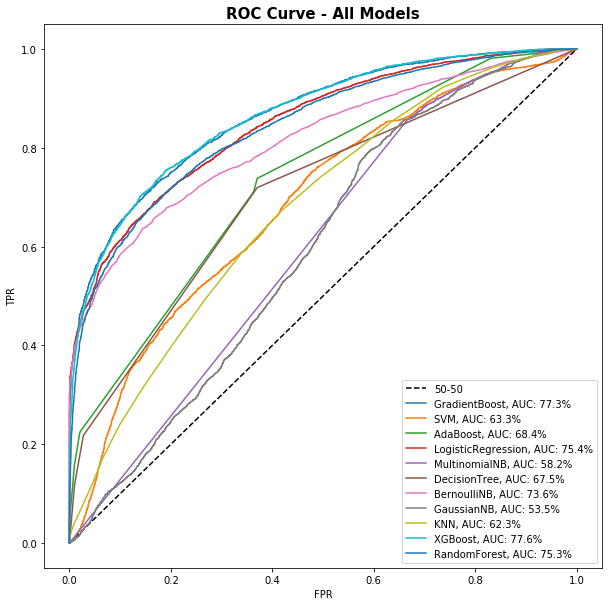

In [18]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange','darkorchid','bisque', 'darkgray']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, value in roc.items():
    label = '{}, AUC: {}%'.format(key, round(100*value[1],1))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models',fontweight='bold',fontsize=15)
ax.legend(loc='best')
plt.savefig('charts/roc_ds2_p1.png')

In [17]:
rd = pd.DataFrame(results_dict).T
rd = rd.apply(lambda x: round(100*x,1).astype(str) + "%")
# rd['f1_success'] = rd['f1']
rd = rd.sort_values(['auc'],ascending=[False])
rd

,accuracy,auc,f1_f,f1_s,precision_f,precision_s,recall_f,recall_s
XGBoost,77.6%,77.6%,75.9%,79.1%,73.9%,81.0%,78.0%,77.3%
GradientBoost,77.2%,77.3%,75.6%,78.7%,73.3%,80.9%,78.0%,76.6%
LogisticRegression,75.3%,75.4%,73.5%,76.9%,71.3%,79.0%,75.9%,74.9%
RandomForest,75.5%,75.3%,73.0%,77.5%,72.6%,77.9%,73.4%,77.2%
BernoulliNB,73.3%,73.6%,72.1%,74.3%,68.1%,78.6%,76.7%,70.5%
AdaBoost,68.9%,68.4%,64.7%,72.2%,66.4%,70.8%,63.0%,73.8%
DecisionTree,67.9%,67.5%,63.9%,71.1%,64.9%,70.3%,63.0%,71.9%
SVM,64.7%,63.3%,55.8%,70.6%,64.1%,65.0%,49.4%,77.2%
KNN,63.4%,62.3%,55.5%,69.0%,61.6%,64.5%,50.6%,74.0%
MultinomialNB,61.4%,58.2%,37.4%,72.1%,69.7%,59.7%,25.5%,90.9%
